## import os 

In [1]:
import os
os.listdir()

['second_model.ipynb',
 'train.csv',
 'DataCleaning.ipynb',
 'EDA.ipynb',
 'PA_201605-2012001更新R6(20190509).xlsx',
 'tag盤點表.xlsx',
 'xgboost.ipynb',
 'LSTM.ipynb',
 'train_FeatureSelected.csv',
 'feature select.ipynb',
 'tpot_pa_pipeline.py',
 'TPOT.ipynb',
 'three_model.ipynb',
 'cnn-time-stack.ipynb',
 '.ipynb_checkpoints']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

# load

In [3]:
df = pd.read_csv('train_FeatureSelected.csv',index_col = 0,parse_dates = True)
print(df.shape)
df.head()

(130795, 31)


,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,MLPAP_TI-0706B12,MLPAP_TI-0706B22,MLPAP_TI-0706B24,MLPAP_TI-0716A09,...,MLPAP_LIC-0738.PV,MLPAP_PIC-0761.PV,MLPAP_LRC-0729.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_FR-0755.PV,MLPAP_FR-0791.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
2016-05-10 08:10:00,421.996112,424.995929,398.999278,397.000005,394.002688,391.997199,391.004787,392.001755,392.004498,403.000684,...,34.707643,49.114940,34.926437,62.161964,181.607147,4.215451,13.177441,0.056350,0.054001,0.914110
2016-05-10 08:20:00,421.996112,425.041541,398.999278,397.000005,394.002688,391.997199,391.004787,392.001755,392.100484,403.000684,...,35.980597,49.137430,35.494560,62.267876,181.084756,4.236381,13.231014,0.084738,0.054001,0.919733
2016-05-10 08:30:00,421.996112,425.109958,398.999278,397.000005,394.002688,391.997199,391.004787,392.001755,392.004498,403.000684,...,33.797872,49.135555,34.616724,62.465860,177.599662,4.227079,13.221490,0.091835,0.054001,0.926436
2016-05-10 15:40:00,421.715731,427.687003,399.252972,395.446261,392.002989,389.622951,388.497742,390.200259,390.052790,403.578089,...,33.567251,49.169289,35.013840,62.394249,178.771310,4.248009,15.014401,0.496363,0.054001,0.887063
2016-05-10 23:40:00,421.003993,428.097506,397.996033,393.996100,390.654621,388.002611,387.000171,388.999261,388.197068,403.000684,...,35.167069,49.143052,34.719328,62.322638,182.122076,4.245102,15.637040,0.208935,0.054001,0.906869


# scale

In [4]:
from sklearn.preprocessing import MinMaxScaler

x_col = df.drop('target',axis=1).columns.tolist()
y_col = 'target'

sc = MinMaxScaler()
df[x_col] = sc.fit_transform(df[x_col])

df.head()

,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,MLPAP_TI-0706B12,MLPAP_TI-0706B22,MLPAP_TI-0706B24,MLPAP_TI-0716A09,...,MLPAP_LIC-0738.PV,MLPAP_PIC-0761.PV,MLPAP_LRC-0729.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_FR-0755.PV,MLPAP_FR-0791.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
2016-05-10 08:10:00,1.000000,0.959951,0.762128,0.801765,0.803969,0.850864,0.879250,1.000000,0.998497,0.807452,...,0.330309,0.785204,0.501066,0.564377,0.517175,0.091985,0.057702,0.909629,0.145166,0.914110
2016-05-10 08:20:00,1.000000,0.960438,0.762128,0.801765,0.803969,0.850864,0.879250,1.000000,1.000000,0.807452,...,0.342830,0.792992,0.509454,0.572779,0.504608,0.092991,0.059449,0.910392,0.145166,0.919733
2016-05-10 08:30:00,1.000000,0.961169,0.762128,0.801765,0.803969,0.850864,0.879250,1.000000,0.998497,0.807452,...,0.321360,0.792343,0.496493,0.588485,0.420766,0.092544,0.059139,0.910583,0.145166,0.926436
2016-05-10 15:40:00,0.996931,0.988679,0.765160,0.781226,0.775964,0.815467,0.841400,0.970583,0.967931,0.814403,...,0.319091,0.804023,0.502357,0.582804,0.448953,0.093549,0.117617,0.921462,0.145166,0.887063
2016-05-10 23:40:00,0.989139,0.993061,0.750138,0.762057,0.757081,0.791310,0.818791,0.950972,0.938868,0.807452,...,0.334828,0.794938,0.498008,0.577123,0.529563,0.093410,0.137926,0.913732,0.145166,0.906869


# stack

In [5]:
def train_windows(df, ref_day=15, predict_day=1):
    X_train, Y_train, i_lst = [], [], []
    for i in tqdm(range(df.shape[0]-predict_day-ref_day)):
        X_train.append(np.array(df.iloc[i:i+ref_day][x_col]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day][y_col]))
        i_lst.append(df.iloc[i+ref_day:i+ref_day+predict_day].index[0])
    return np.array(X_train), np.array(Y_train), i_lst

In [6]:
X, y, i_lst = train_windows(df, ref_day=30, predict_day=1)
print(len(X),len(y),len(i_lst))

/workspace/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



130764 130764 130764


In [7]:
y = pd.Series(y.ravel(),index=i_lst,name='y')
y.head()

2016-05-13 14:20:00    0.894376
2016-05-13 15:00:00    0.903985
2016-05-13 15:10:00    0.888306
2016-05-13 15:20:00    0.894056
2016-05-13 15:30:00    0.889209
Name: y, dtype: float64

# Visualization

(30, 30)


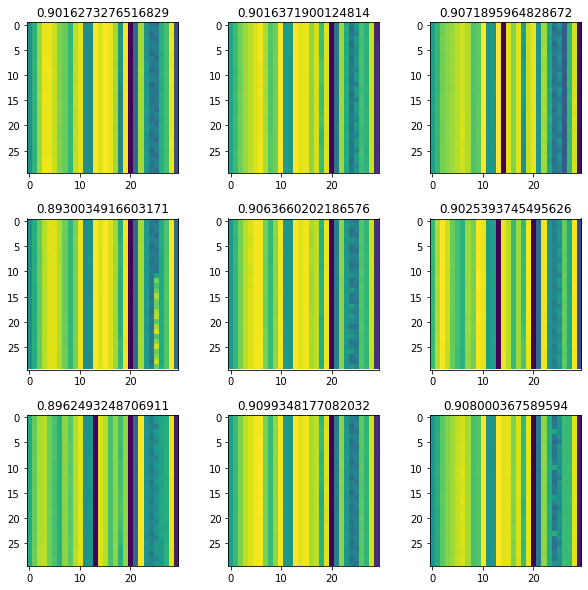

In [8]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0.3, hspace =0.3)
print(X[0].shape)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    idx = np.random.randint(0,len(X))
    plt.imshow(X[idx])
    plt.title(y[idx])

# reshape

In [9]:
X = X.reshape(-1,X[0].shape[0],X[0].shape[1],1)
print(X.shape,y.shape)

(130764, 30, 30, 1) (130764,)


# split

In [10]:
train_len = int(len(df)*0.8)
X_train,X_val_test = X[:train_len],X[train_len:]
y_train,y_val_test = y[:train_len],y[train_len:]

val_len = int(len(X_val_test)*0.5)
X_val,X_test = X_val_test[:val_len],X_val_test[val_len:]
y_val,y_test = y_val_test[:val_len],y_val_test[val_len:]

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(104636, 30, 30, 1) (104636,)
(13064, 30, 30, 1) (13064,)
(13064, 30, 30, 1) (13064,)


# Model

In [11]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam
import warnings;warnings.simplefilter('ignore')

Using TensorFlow backend.
/workspace/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/workspace/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/workspace/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/workspace/conda/lib/python3.6/site-packages/tensorflow/python/framework/d

In [12]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=X[0].shape))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1843328   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total para

In [13]:
model.compile(optimizer=Adam(lr=0.0001), loss="mse", metrics=["mse"])

In [14]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,mode='min')

# fit

In [15]:
history = model.fit(X_train,y_train,
                    batch_size = 256,
                    epochs = 10,
                    validation_data = (X_val,y_val),
                    verbose = 1,
                    callbacks = [es])

Train on 104636 samples, validate on 13064 samples
Epoch 1/10
104636/104636 [==============================] - 7s 66us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 2.9755e-04 - val_mean_squared_error: 2.9755e-04
Epoch 2/10
104636/104636 [==============================] - 4s 35us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 2.5834e-04 - val_mean_squared_error: 2.5834e-04
Epoch 3/10
104636/104636 [==============================] - 4s 35us/step - loss: 7.3051e-04 - mean_squared_error: 7.3051e-04 - val_loss: 2.9914e-04 - val_mean_squared_error: 2.9914e-04
Epoch 4/10
104636/104636 [==============================] - 4s 35us/step - loss: 4.6340e-04 - mean_squared_error: 4.6340e-04 - val_loss: 2.4604e-04 - val_mean_squared_error: 2.4604e-04
Epoch 5/10
104636/104636 [==============================] - 4s 35us/step - loss: 3.5767e-04 - mean_squared_error: 3.5767e-04 - val_loss: 2.0195e-04 - val_mean_squared_error: 2.0195e-04
Epoch 6/10
104636/104636 [==============

# eval

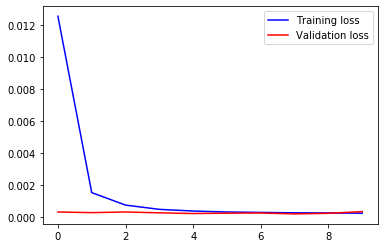

In [16]:
n = 0
plt.plot(history.history['loss'][n:], color='b', label="Training loss")
plt.plot(history.history['val_loss'][n:], color='r', label="Validation loss")
plt.legend()

In [17]:
import gc 
gc.collect()

2616

# plot predict line

In [18]:
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def metric(y_true,y_pred,name):
    t = pd.DataFrame(index=[name])
    t['r2'] = r2_score(y_true,y_pred)
    t['rmse'] = sqrt(mean_squared_error(y_true,y_pred))
    t['mape'] = mape(y_true,y_pred)
    t = t.apply(lambda x:round(x,4))
    return t

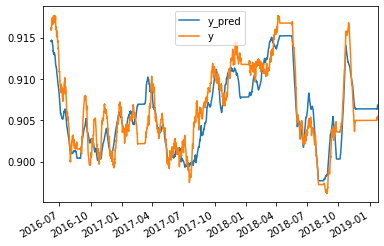

,r2,rmse,mape
train,0.1723,0.0096,0.807


In [40]:
# predict
y_pred = model.predict(X_train).ravel()
y_pred = pd.Series(y_pred,index=y_train.index,name='y_pred')

# sort index
y_pred = y_pred.sort_index()
y_train = y_train.sort_index()

# plot
plot_data = pd.concat([y_pred,y_train],axis=1)
plot_data.rolling(6*24*15).mean().plot()
plt.show()

# score
metric(y_train,y_pred,'train')

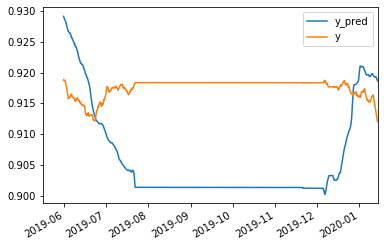

,r2,rmse,mape
test,-1.4475,0.0153,1.2792


In [41]:
from sklearn.metrics import r2_score,mean_squared_error

# predict
y_pred = model.predict(X_test).ravel()
y_pred = pd.Series(y_pred,index=y_test.index,name='y_pred')

# sort index
y_pred = y_pred.sort_index()
y_test = y_test.sort_index()

# plot
plot_data = pd.concat([y_pred,y_test],axis=1)
plot_data.rolling(6*24*15).mean().plot()
plt.show()

# score
metric(y_test,y_pred,'test')